In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Lambda
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import to_categorical

### Решить задачу многоклассовой классификации с помощью многослойной нейронной сети, состоящей из полносвязных слоев.

In [30]:
# загружаем данные и разбиваем их на составляющие
train = pd.read_csv("./train.csv")
y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)

In [31]:

X_train = normalize(X_train.astype('float32'), axis=1)

# Из файла информацию о изображения с цифрами мы получили в виде одномерных векторов из 784 значений
# Переформируем все данные в трехмерные матрицы 28x28x1.
# Keras требует дополнительное измерение в конце, для каналов. 
# Если бы это были RGB-изображения, то было бы 3 канала, но поскольку у нас "черно-белое" изображение, мы указываем 1 серый канал.
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

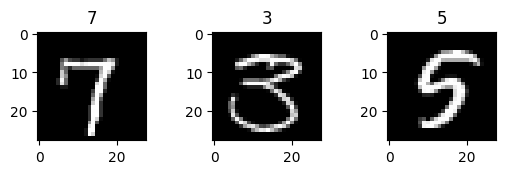

In [32]:
# убедимся, что все ок, выведем сами тестовые изображения и соответствующие им цифры 
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])

In [33]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

# Нормализуем данные
def normalize(x): 
    return (x-mean_px)/std_px

Метки в данном случае представлены целыми числами от 0 до 9. 
Нам нужно применить one-hot encoding, чтобы преобразовать эти one-hot числовой массив (например: 2 -> [0,0,1,0,0,0,0,0,0,0,0]).

In [34]:
print(f"{y_train[0]} преобрауется в ")
y_train = to_categorical(y_train, num_classes = 10)
# Пример:
print(y_train[0])

1 преобрауется в 
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [36]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

In [37]:
model = Sequential()
model.add(Lambda(normalize,input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(128, activation='relu')),
model.add(Dense(128, activation='relu')),
model.add(Dense(10, activation='softmax'))

In [38]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Определим callback для сохранения весов на каждой этапе обучения
# Это понадобится позже для определения параметров, при которых точность максимальна
checkpoint_callback = ModelCheckpoint(
    filepath='weights.{epoch:02d}.h5',
    save_weights_only=True,
    save_best_only=False,
    verbose=1
)

history = model.fit(datagen.flow(X_train, y_train, batch_size=16),
                    epochs=29, 
                    verbose=1,
                    validation_data=(X_test, y_test), callbacks=[checkpoint_callback])

loss, accuracy = model.evaluate(X_test, y_test)

print(f"Final loss: {loss}")
print(f"Final accuracy: {accuracy}")


Epoch 1/29
2095/2100 [============================>.] - ETA: 0s - loss: 0.4871 - accuracy: 0.8424
Epoch 1: saving model to weights.01.h5
2100/2100 [==============================] - 14s 6ms/step - loss: 0.4870 - accuracy: 0.8425 - val_loss: 0.2515 - val_accuracy: 0.9202
Epoch 2/29
2100/2100 [==============================] - ETA: 0s - loss: 0.2626 - accuracy: 0.9185
Epoch 2: saving model to weights.02.h5
2100/2100 [==============================] - 16s 7ms/step - loss: 0.2626 - accuracy: 0.9185 - val_loss: 0.1572 - val_accuracy: 0.9538
Epoch 3/29
2098/2100 [============================>.] - ETA: 0s - loss: 0.2170 - accuracy: 0.9329
Epoch 3: saving model to weights.03.h5
2100/2100 [==============================] - 14s 7ms/step - loss: 0.2170 - accuracy: 0.9329 - val_loss: 0.1264 - val_accuracy: 0.9602
Epoch 4/29
2097/2100 [============================>.] - ETA: 0s - loss: 0.1914 - accuracy: 0.9397
Epoch 4: saving model to weights.04.h5
2100/2100 [==============================] - 14s 7

In [40]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Посмотрим, как происходило изменение точности на каждой из эпох

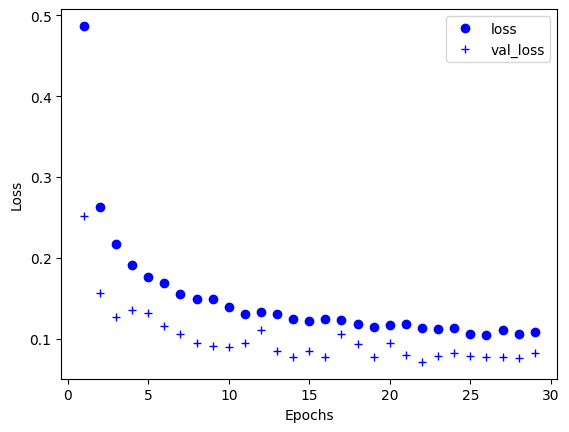

In [47]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo')
plt.plot(epochs, val_loss_values, 'b+')
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

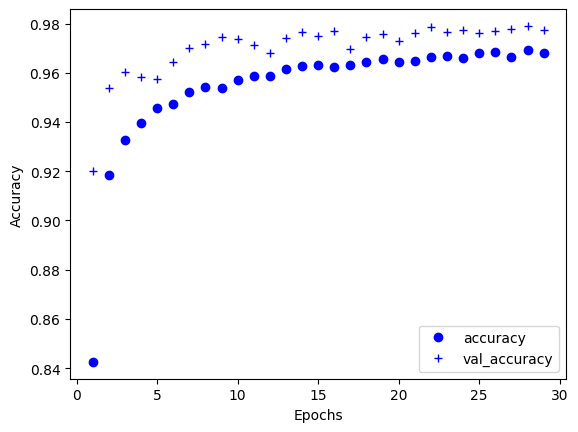

In [48]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo')
plt.plot(epochs, val_acc_values, 'b+')
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

### Вычислить градиент целевой функции по обучаемым параметрам нейронной сети, сравнить полученные значения со значениями, вычисленными с помощью библиотечных функций

In [43]:
# Найдем эпоху с наивысшей точностью валидации
best_epoch = np.argmax(history.history['val_accuracy'])
best_accuracy = history.history['val_accuracy'][best_epoch]

# Получим веса модели для этой эпохи из файла, сохраненного ранее на этапе обучения
model.load_weights(f'weights.{best_epoch+1:02d}.h5')

# Получим параметры модели для лучшей эпохи
best_parameters = model.get_weights()

print(f"Best accuracy: {best_accuracy}")
print("Best params:")
for layer_param in best_parameters:
    print(layer_param)

Best accuracy: 0.9790475964546204
Best params:
[[ 0.07339697  0.1281565   0.13618346 ...  0.14385054  0.15881875
   0.25441962]
 [ 0.08194564  0.11939254  0.20486127 ...  0.09638471  0.11861615
   0.13689826]
 [ 0.1622842   0.08663205  0.19660623 ...  0.14094059  0.10748278
   0.17209455]
 ...
 [ 0.06761391 -0.03229456  0.17304061 ... -0.00842601  0.14061764
   0.1960472 ]
 [ 0.09847224  0.08989424  0.25271535 ...  0.11931877  0.10632395
   0.21829408]
 [ 0.11674468  0.10395157  0.16281047 ...  0.06573924  0.11271806
   0.1371498 ]]
[-0.12091871 -0.07295922 -0.17320985  0.13195518 -0.0544329  -0.07580148
 -0.12837742 -0.12326887 -0.03688931 -0.14901394 -0.11621713  0.00430297
 -0.08852132 -0.24827382 -0.11041967 -0.13118896 -0.11356082 -0.13770157
 -0.11202147 -0.04329206 -0.10650682  0.04061216 -0.22848569 -0.07552306
 -0.05078715 -0.14170176 -0.07029857  0.01927406 -0.09613718 -0.00229663
 -0.16468582 -0.1997996  -0.06262368 -0.10568061 -0.1630225  -0.09957252
  0.02161248 -0.0336112

### Определить параметры нейронной сети, при которых точность классификации максимальна

Чтобы определить параметры нейронной сети, при которых точность классификации максимальна, мы
- должны проанализировать объект history, возвращаемый методом fit(), который содержит историю обучения, включая значения точности для каждой эпохи;
- найти эпоху с лучшей точностью проверки;
- по мере обучения модели мы сохраняем веса, полученные на каждой эпохе, в отдельный файл. Загрузим веса из файла соответсвующего эпохе с лучшей точностью;
- используем model.get_weights() для получения параметров (весов и смещений) модели в лучшую эпоху. Мы перебираем параметры и выводим их формы, чтобы проверить размеры параметров каждого слоя.

In [44]:
# Найдем эпоху с наивысшей точностью валидации
best_epoch = np.argmax(history.history['val_accuracy'])
best_accuracy = history.history['val_accuracy'][best_epoch]

# Получим веса модели для этой эпохи из файла, сохраненного ранее на этапе обучения
model.load_weights(f'weights.{best_epoch+1:02d}.h5')

# Получим параметры модели для лучшей эпохи
best_parameters = model.get_weights()

print(f"Best accuracy: {best_accuracy}")
print("Best params:")
for layer_param in best_parameters:
    print(layer_param)

Best accuracy: 0.9790475964546204
Best params:
[[ 0.07339697  0.1281565   0.13618346 ...  0.14385054  0.15881875
   0.25441962]
 [ 0.08194564  0.11939254  0.20486127 ...  0.09638471  0.11861615
   0.13689826]
 [ 0.1622842   0.08663205  0.19660623 ...  0.14094059  0.10748278
   0.17209455]
 ...
 [ 0.06761391 -0.03229456  0.17304061 ... -0.00842601  0.14061764
   0.1960472 ]
 [ 0.09847224  0.08989424  0.25271535 ...  0.11931877  0.10632395
   0.21829408]
 [ 0.11674468  0.10395157  0.16281047 ...  0.06573924  0.11271806
   0.1371498 ]]
[-0.12091871 -0.07295922 -0.17320985  0.13195518 -0.0544329  -0.07580148
 -0.12837742 -0.12326887 -0.03688931 -0.14901394 -0.11621713  0.00430297
 -0.08852132 -0.24827382 -0.11041967 -0.13118896 -0.11356082 -0.13770157
 -0.11202147 -0.04329206 -0.10650682  0.04061216 -0.22848569 -0.07552306
 -0.05078715 -0.14170176 -0.07029857  0.01927406 -0.09613718 -0.00229663
 -0.16468582 -0.1997996  -0.06262368 -0.10568061 -0.1630225  -0.09957252
  0.02161248 -0.0336112

In [45]:
print("Описание модели:")
model.summary()

Описание модели:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 28, 28, 1)         0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118282 (462.04 KB)
Trainable params: 118282 (462.04 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________________________